<font style='font-size:2.5em'>**Part I: Data Cleaning and Outlier Detection** </font>

## Import Libraries

First, we import the necessary libraries.

In [163]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [164]:
df_germany = pd.read_excel('../data/imf_GERMANY_data.xlsx')

# Load the second XLSX file into a DataFrame
df_us = pd.read_excel('../data/imf_US_data.xlsx')

In [165]:
df_germany.rename(columns={'International Financial Statistics (IFS)': 'Month'}, inplace=True)

# Rename the unnamed columns based on the provided names
new_column_names = [
    'Month',
    'Economic Activity, Industrial Production, Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
    'Prices, Consumer Price Index, All items, Index'
]
df_germany.columns = new_column_names
df_germany = df_germany.drop([0, 1])

In [166]:
df_us.rename(columns={'International Financial Statistics (IFS)': 'Month'}, inplace=True)

# Rename the unnamed columns based on the provided names
new_column_names1 = [
    'Month',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
    'Prices, Consumer Price Index, All items, Index'
]

df_us.columns = new_column_names1
df_us = df_us.drop([0, 1,])

df_germany['Country'] = 'Germany'
df_us['Country'] = 'US'

# Merge the two DataFrames
merged_df = pd.concat([df_germany, df_us], ignore_index=True)


In [167]:
columns = ['Month', 'Country', 'Economic Activity, Industrial Production, Index',
           'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
           'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
           'Prices, Consumer Price Index, All items, Index']

merged_df = merged_df[columns]


In [168]:
df_germany = merged_df[merged_df['Country'] == 'Germany']
df_us = merged_df[merged_df['Country'] == 'US']

# Reset index for both DataFrames
df_germany.reset_index(drop=True, inplace=True)
df_us.reset_index(drop=True, inplace=True)

# Calculate the ratio of US CPI to Germany CPI
cpi_ratio = df_us['Prices, Consumer Price Index, All items, Index'].values / df_germany['Prices, Consumer Price Index, All items, Index'].values

# Calculate the monthly growth in the nominal exchange rate for Germany
df_germany['Real Exchange Rate'] = cpi_ratio * df_germany['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate']

# Add the new variable to the original merged DataFrame
merged_df.loc[merged_df['Country'] == 'Germany', 'Real Exchange Rate'] = df_germany['Real Exchange Rate']

# Rename the column
merged_df.rename(columns={'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate': 'Nominal Exchange Rate'}, inplace=True)



C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\3081440155.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_germany['Real Exchange Rate'] = cpi_ratio * df_germany['Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate']


In [169]:
# Calculate the percentage change in the nominal exchange rate only for Germany
merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate"].pct_change() * 100
)

# Calculate the percentage change in the real exchange rate only for Germany
merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"].pct_change() * 100
)




C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\1448738395.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Nominal Exchange Rate"].pct_change() * 100
C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\1448738395.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"].pct_change() * 100


In [170]:
# Filter for Germany and find the Real Exchange Rate for December 1990
rer_dec_1990 = merged_df.loc[(merged_df["Country"] == "Germany") & 
                             (merged_df["Month"] == "Dec 1990"), 
                             "Real Exchange Rate"].values[0]

# Construct the RER Index for Germany
merged_df.loc[merged_df["Country"] == "Germany", "RER_Index"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Real Exchange Rate"] / rer_dec_1990
)

In [171]:
merged_df

,Month,Country,"Economic Activity, Industrial Production, Index",Nominal Exchange Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar","Prices, Consumer Price Index, All items, Index",Real Exchange Rate,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index
0,Dec 1959,Germany,32.500305,4.2,4811.474341,24.616929,2.300359,NaN,NaN,1.713301
1,Jan 1960,Germany,31.193881,4.2,4724.155785,24.616929,2.292535,0.0,-0.340136,1.707474
2,Feb 1960,Germany,31.041599,4.2,4806.36283,24.477068,2.313504,0.0,0.914640,1.723091
3,Mar 1960,Germany,32.203755,4.2,4966.456016,24.477068,2.313504,0.0,0.000000,1.723091
4,Apr 1960,Germany,34.287622,4.2,5236.120624,24.616929,2.308184,0.0,-0.229943,1.719129
...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,NaN,NaN,78908.838357,60.351608,NaN,NaN,NaN,NaN
742,Sep 1990,US,NaN,NaN,80024.166133,60.856066,NaN,NaN,NaN,NaN
743,Oct 1990,US,NaN,NaN,82852.196532,61.222946,NaN,NaN,NaN,NaN
744,Nov 1990,US,NaN,NaN,83059.402774,61.360525,NaN,NaN,NaN,NaN


In [172]:
# Compute Monthly Inflation Growth (%) for both US and Germany
merged_df["Monthly Inflation Growth (%)"] = merged_df.groupby("Country")[
    "Prices, Consumer Price Index, All items, Index"
].pct_change() * 100

pd.reset_option("display.max_rows")


In [173]:
# Compute Monthly Industrial Production Growth (%) for only Germany
merged_df.loc[merged_df["Country"] == "Germany", "Monthly Industrial Production Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change() * 100
)

# Compute Yearly Industrial Production Growth (%) for only Germany (12-month difference)
merged_df.loc[merged_df["Country"] == "Germany", "Industrial Production YoY Growth (%)"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change(periods=12) * 100
)
merged_df

C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\2244374788.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change() * 100
C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\2244374788.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.loc[merged_df["Country"] == "Germany", "Economic Activity, Industrial Production, Index"].pct_change(periods=12) * 100


,Month,Country,"Economic Activity, Industrial Production, Index",Nominal Exchange Rate,"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar","Prices, Consumer Price Index, All items, Index",Real Exchange Rate,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,32.500305,4.2,4811.474341,24.616929,2.300359,NaN,NaN,1.713301,NaN,NaN,NaN
1,Jan 1960,Germany,31.193881,4.2,4724.155785,24.616929,2.292535,0.0,-0.340136,1.707474,0.0,-4.019729,NaN
2,Feb 1960,Germany,31.041599,4.2,4806.36283,24.477068,2.313504,0.0,0.914640,1.723091,-0.568147,-0.488181,NaN
3,Mar 1960,Germany,32.203755,4.2,4966.456016,24.477068,2.313504,0.0,0.000000,1.723091,0.0,3.743868,NaN
4,Apr 1960,Germany,34.287622,4.2,5236.120624,24.616929,2.308184,0.0,-0.229943,1.719129,0.571393,6.470881,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,NaN,NaN,78908.838357,60.351608,NaN,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,NaN,NaN,80024.166133,60.856066,NaN,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,NaN,NaN,82852.196532,61.222946,NaN,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,NaN,NaN,83059.402774,61.360525,NaN,NaN,NaN,NaN,0.224719,NaN,NaN


In [174]:
# Find the base value of international reserves for January 1960 separately for Germany & US
germany_base_reserves = merged_df.loc[
    (merged_df["Country"] == "Germany") & (merged_df["Month"] == "Jan 1960"),
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"
].values[0]

us_base_reserves = merged_df.loc[
    (merged_df["Country"] == "US") & (merged_df["Month"] == "Jan 1960"),
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"
].values[0]

# Compute the International Reserves Index for Germany
merged_df.loc[merged_df["Country"] == "Germany", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] = (
    merged_df.loc[merged_df["Country"] == "Germany", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] / germany_base_reserves * 100
)

# Compute the International Reserves Index for the US
merged_df.loc[merged_df["Country"] == "US", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] = (
    merged_df.loc[merged_df["Country"] == "US", "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar"] / us_base_reserves * 100
)

merged_df.rename(
    columns={"International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": 
             "International Reserves Index"}, 
    inplace=True
)

# Display first few rows to verify
merged_df


,Month,Country,"Economic Activity, Industrial Production, Index",Nominal Exchange Rate,International Reserves Index,"Prices, Consumer Price Index, All items, Index",Real Exchange Rate,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,32.500305,4.2,101.848342,24.616929,2.300359,NaN,NaN,1.713301,NaN,NaN,NaN
1,Jan 1960,Germany,31.193881,4.2,100.0,24.616929,2.292535,0.0,-0.340136,1.707474,0.0,-4.019729,NaN
2,Feb 1960,Germany,31.041599,4.2,101.740143,24.477068,2.313504,0.0,0.914640,1.723091,-0.568147,-0.488181,NaN
3,Mar 1960,Germany,32.203755,4.2,105.128964,24.477068,2.313504,0.0,0.000000,1.723091,0.0,3.743868,NaN
4,Apr 1960,Germany,34.287622,4.2,110.837171,24.616929,2.308184,0.0,-0.229943,1.719129,0.571393,6.470881,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,NaN,NaN,367.39208,60.351608,NaN,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,NaN,NaN,372.584941,60.856066,NaN,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,NaN,NaN,385.751982,61.222946,NaN,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,NaN,NaN,386.716715,61.360525,NaN,NaN,NaN,NaN,0.224719,NaN,NaN


In [175]:
# List of columns to drop
columns_to_drop = [
    'Economic Activity, Industrial Production, Index',
    
'Prices, Consumer Price Index, All items, Index',
    'Real Exchange Rate',
]

# Drop the columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')


In [176]:
merged_df

,Month,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,4.2,101.848342,NaN,NaN,1.713301,NaN,NaN,NaN
1,Jan 1960,Germany,4.2,100.0,0.0,-0.340136,1.707474,0.0,-4.019729,NaN
2,Feb 1960,Germany,4.2,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,NaN
3,Mar 1960,Germany,4.2,105.128964,0.0,0.000000,1.723091,0.0,3.743868,NaN
4,Apr 1960,Germany,4.2,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,NaN
...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,NaN,367.39208,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,NaN,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,NaN,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,NaN,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


In [177]:
# Define a function to detect strict (fewer) outliers
def detect_outliers_strict(df, column, iqr_threshold=2.5, z_threshold=3.0):  
    # Compute IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - iqr_threshold * IQR
    upper_bound_iqr = Q3 + iqr_threshold * IQR
    
    # Compute Z-score bounds
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound_z = mean - z_threshold * std_dev
    upper_bound_z = mean + z_threshold * std_dev

    # Ensure fewer values are flagged (outliers must violate both conditions)
    return (df[column] < lower_bound_iqr) & (df[column] < lower_bound_z) | \
           (df[column] > upper_bound_iqr) & (df[column] > upper_bound_z)

# Apply function to numeric columns
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
outlier_locations = []

for col in numeric_columns:
    outliers = detect_outliers_strict(merged_df, col, iqr_threshold=2.5, z_threshold=3.0)
    
    # Store row index, month, column, and outlier value
    for index in merged_df[outliers].index:
        outlier_locations.append((index, merged_df.loc[index, "Month"], col, merged_df.loc[index, col]))

# Convert outlier locations to a DataFrame for easier viewing
outliers_df = pd.DataFrame(outlier_locations, columns=["Row Index", "Month", "Column", "Outlier Value"])

# Display detected outliers with the Month column
print("Detected Outliers with Month Information:")
print(outliers_df)


Detected Outliers with Month Information:
    Row Index     Month                                Column  Outlier Value
0         119  Nov 1969      Nominal Exchange Rate Growth (%)      -8.500000
1         162  Jun 1973      Nominal Exchange Rate Growth (%)      -7.669997
2         163  Jul 1973      Nominal Exchange Rate Growth (%)      -9.474501
3         167  Nov 1973      Nominal Exchange Rate Growth (%)       6.913703
4         254  Feb 1981      Nominal Exchange Rate Growth (%)       6.774258
5         119  Nov 1969         Real Exchange Rate Growth (%)      -8.217983
6         145  Jan 1972         Real Exchange Rate Growth (%)      -7.990670
7         162  Jun 1973         Real Exchange Rate Growth (%)      -7.554545
8         163  Jul 1973         Real Exchange Rate Growth (%)      -9.603880
9         243  Mar 1980         Real Exchange Rate Growth (%)       7.022401
10        254  Feb 1981         Real Exchange Rate Growth (%)       7.043635
11        102  Jun 1968  Industria

In [178]:
# Convert 'Month' to extract year (assuming format 'Jan 1973')
outliers_df['Year'] = outliers_df['Month'].str[-4:].astype(int)

# Define valid year range (±5 years from 1973)
valid_year_range = (outliers_df['Year'] >= 1968) & (outliers_df['Year'] <= 1978)

# Filter out only those outliers that are outside the valid range
outliers_to_replace = outliers_df[~valid_year_range]  # Invert the filter (~)

# Apply NaN to these specific outliers in merged_df
for _, row in outliers_to_replace.iterrows():
    merged_df.loc[row["Row Index"], row["Column"]] = np.nan

# Display summary of changes
print("Outliers replaced with NaN (Years outside 1968-1978):")
print(outliers_to_replace)


Outliers replaced with NaN (Years outside 1968-1978):
    Row Index     Month                            Column  Outlier Value  Year
4         254  Feb 1981  Nominal Exchange Rate Growth (%)       6.774258  1981
9         243  Mar 1980     Real Exchange Rate Growth (%)       7.022401  1980
10        254  Feb 1981     Real Exchange Rate Growth (%)       7.043635  1981


In [179]:
merged_df.loc[254] #check whether the value has been replaced with NaN


Month                                          Feb 1981
Country                                         Germany
Nominal Exchange Rate                            2.1436
International Reserves Index                1139.353417
Nominal Exchange Rate Growth (%)                    NaN
Real Exchange Rate Growth (%)                       NaN
RER_Index                                      1.187437
Monthly Inflation Growth (%)                   0.780227
Monthly Industrial Production Growth (%)       3.293824
Industrial Production YoY Growth (%)          -3.395566
Name: 254, dtype: object

In [180]:
# List of columns where missing values should NOT be handled
columns_to_exclude = [
    "Nominal Exchange Rate Growth (%)",
    "Real Exchange Rate Growth (%)",
    "RER_Index",
    "Monthly Industrial Production Growth (%)",
    "Industrial Production YoY Growth (%)"
]

# Separate data for US (for exclusion in missing value handling)
us_mask = merged_df["Country"] == "US"

# Step 1: Apply interpolation **only to allowed columns** (excluding US for the specific calculations)
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df.loc[~us_mask, col] = merged_df.loc[~us_mask, col].interpolate(method='linear')

# Step 2: Forward-fill and Backward-fill missing values, but **only for allowed columns**
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df[col].ffill(inplace=True)  # Forward fill
        merged_df[col].bfill(inplace=True)  # Backward fill

# Step 3: Special Handling for First Row NaNs
merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs

# Step 4: As a last resort, fill remaining NaNs with column means (except excluded columns)
for col in merged_df.select_dtypes(include=[np.number]).columns:
    if col not in columns_to_exclude:
        merged_df[col].fillna(merged_df[col].mean(), inplace=True)

C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\3976157605.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs
C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\3976157605.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(method="bfill", inplace=True)  # Backward fill first row NaNs
C:\Users\hksid\AppData\Local\Temp\ipykernel_10140\3976157605.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obj

In [181]:
merged_df

,Month,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),RER_Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,Dec 1959,Germany,4.200000,101.848342,0.0,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,Jan 1960,Germany,4.200000,100.000000,0.0,-0.340136,1.707474,0.000000,-4.019729,10.900123
2,Feb 1960,Germany,4.200000,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,10.900123
3,Mar 1960,Germany,4.200000,105.128964,0.0,0.000000,1.723091,0.000000,3.743868,10.900123
4,Apr 1960,Germany,4.200000,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,10.900123
...,...,...,...,...,...,...,...,...,...,...
741,Aug 1990,US,2.938981,367.392080,NaN,NaN,NaN,0.920245,NaN,NaN
742,Sep 1990,US,2.938981,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,Oct 1990,US,2.938981,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,Nov 1990,US,2.938981,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


In [182]:
print("Number of missing values per column:")
print(merged_df.isna().sum())  # Shows NaN count for each column


Number of missing values per column:
Month                                         0
Country                                       0
Nominal Exchange Rate                         0
International Reserves Index                  0
Nominal Exchange Rate Growth (%)            373
Real Exchange Rate Growth (%)               373
RER_Index                                   373
Monthly Inflation Growth (%)                  0
Monthly Industrial Production Growth (%)    373
Industrial Production YoY Growth (%)        373
dtype: int64


In [183]:
# Convert "Month" column to datetime format (assuming format like "Jan 1960")
merged_df["Date"] = pd.to_datetime(merged_df["Month"], format="%b %Y")

# Drop the old "Month" column (optional)
merged_df.drop(columns=["Month"], inplace=True)

# Sort the DataFrame by the new Date column (optional but recommended)
merged_df.sort_values("Date", inplace=True)

# Reset index (optional)
merged_df.reset_index(drop=True, inplace=True)

# Reorder columns: Move "Date" to the first position
cols = ["Date"] + [col for col in merged_df.columns if col != "Date"]
merged_df = merged_df[cols]



In [184]:
# Rename the column
merged_df.rename(columns={"RER_Index": "Real Exchange Rate Index"}, inplace=True)
# Sort by 'Country' first (Germany first, then US), then by 'Date'
merged_df = merged_df.sort_values(by=["Country", "Date"], ascending=[True, True])

# Reset index (optional)
merged_df.reset_index(drop=True, inplace=True)

merged_df


,Date,Country,Nominal Exchange Rate,International Reserves Index,Nominal Exchange Rate Growth (%),Real Exchange Rate Growth (%),Real Exchange Rate Index,Monthly Inflation Growth (%),Monthly Industrial Production Growth (%),Industrial Production YoY Growth (%)
0,1959-12-01,Germany,4.200000,101.848342,0.0,-0.340136,1.713301,0.000000,-4.019729,10.900123
1,1960-01-01,Germany,4.200000,100.000000,0.0,-0.340136,1.707474,0.000000,-4.019729,10.900123
2,1960-02-01,Germany,4.200000,101.740143,0.0,0.914640,1.723091,-0.568147,-0.488181,10.900123
3,1960-03-01,Germany,4.200000,105.128964,0.0,0.000000,1.723091,0.000000,3.743868,10.900123
4,1960-04-01,Germany,4.200000,110.837171,0.0,-0.229943,1.719129,0.571393,6.470881,10.900123
...,...,...,...,...,...,...,...,...,...,...
741,1990-08-01,US,2.938981,367.392080,NaN,NaN,NaN,0.920245,NaN,NaN
742,1990-09-01,US,2.938981,372.584941,NaN,NaN,NaN,0.835866,NaN,NaN
743,1990-10-01,US,2.938981,385.751982,NaN,NaN,NaN,0.602864,NaN,NaN
744,1990-11-01,US,2.938981,386.716715,NaN,NaN,NaN,0.224719,NaN,NaN


<font style='font-size:2.5em'>**Part II: Data Visualisation** </font>

<font style='font-size:1.25em'>**5.2.1 Exchange Rate and International Reserve Graphs** </font>

Germany's exit from the Bretton Woods system occurred in March 1973, and we will be reflecting this in the visualistions below showing: 
-  The monthly growth in the nominal exchange rate.
- The level of the nominal exchange rate.
-  The monthly growth in the real exchange rate.
-  The real exchange rate index

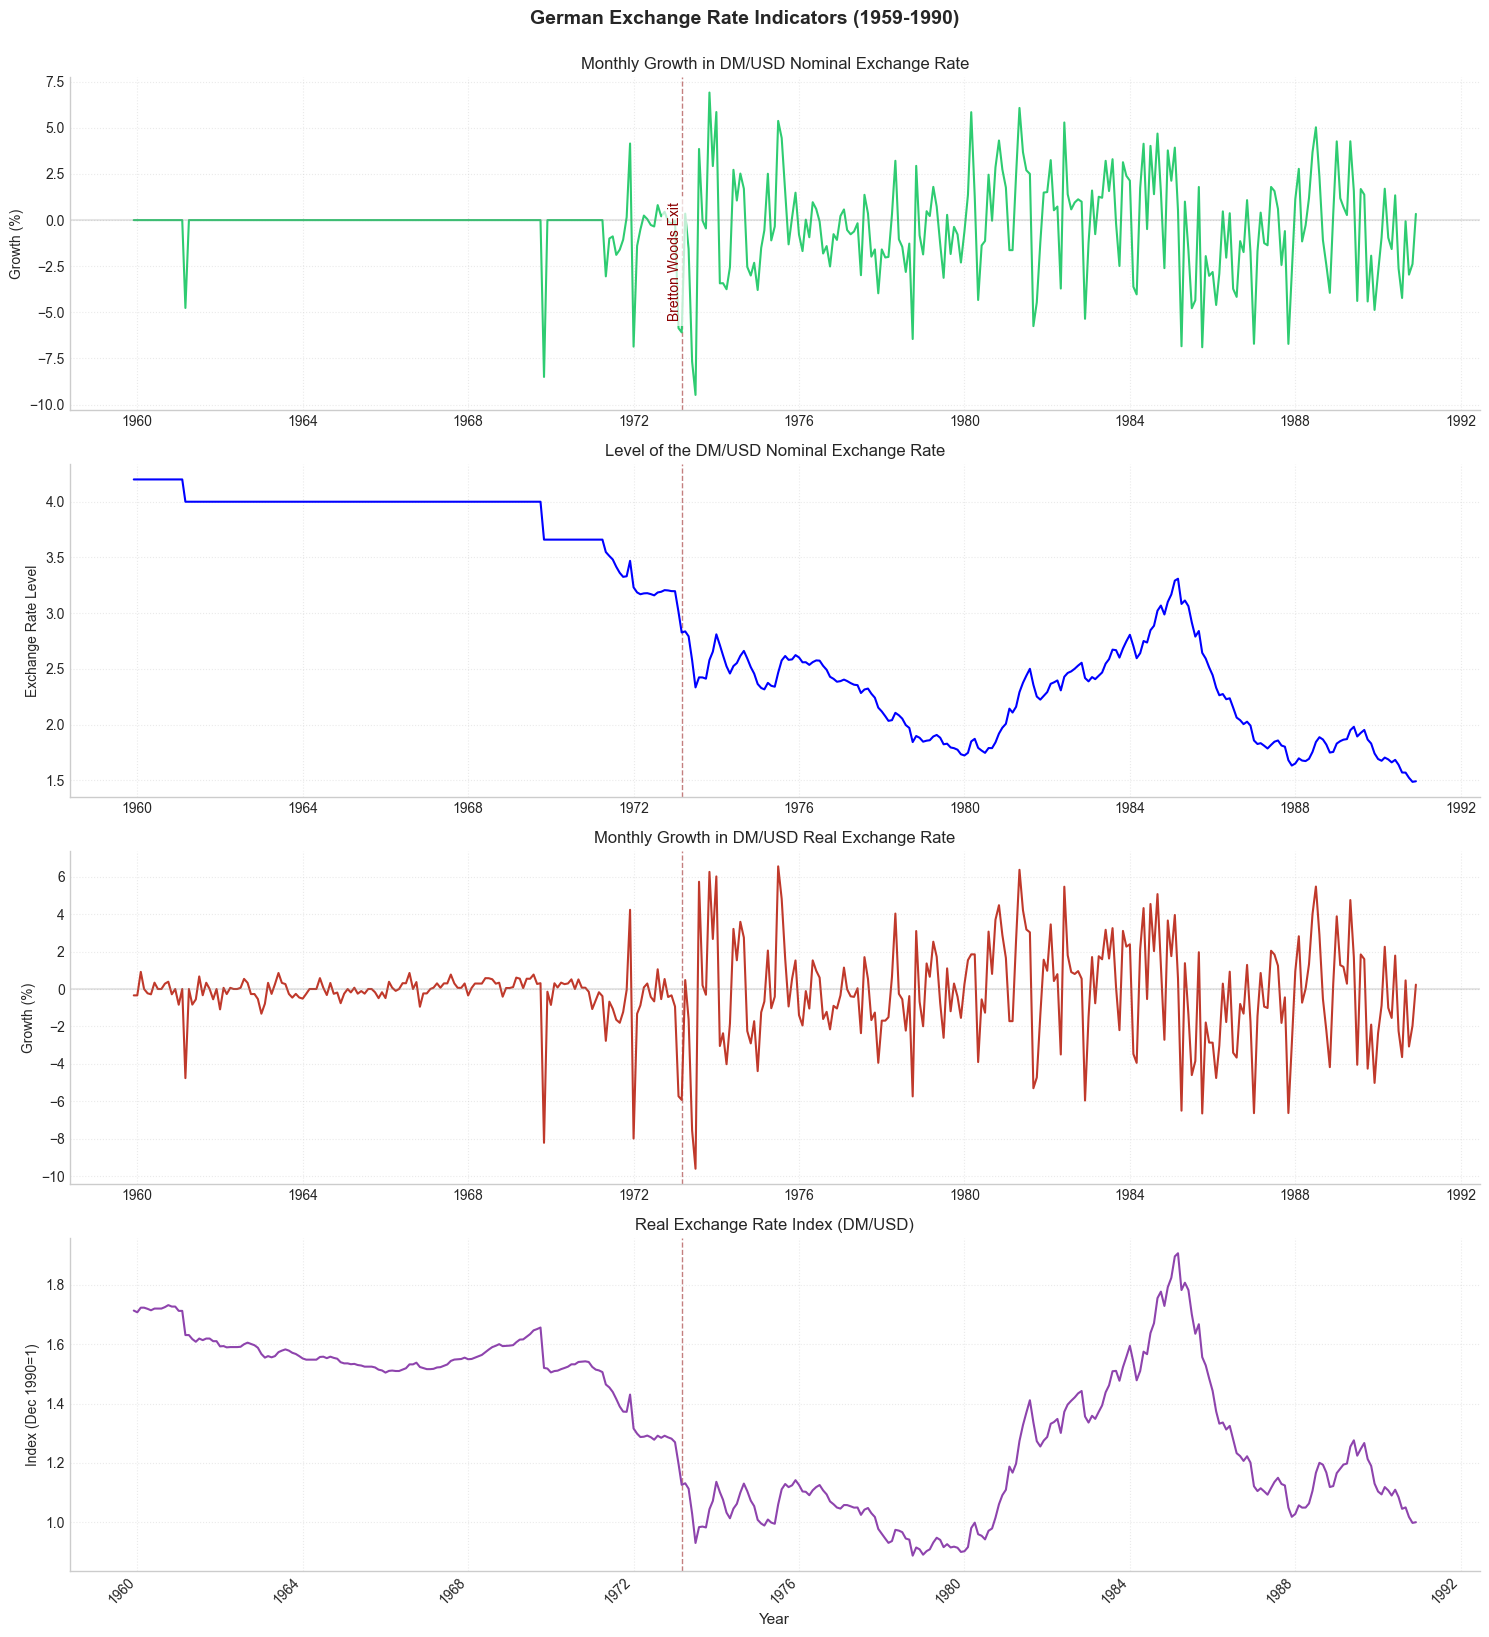

In [185]:
# Filter data for Germany only
germany_df = merged_df[merged_df["Country"] == "Germany"]

# Define Bretton Woods exit date
bretton_woods_exit = pd.to_datetime('1973-03-01')

# Set style and figure
plt.style.use('seaborn-v0_8-whitegrid')  
fig, axs = plt.subplots(4, 1, figsize=(15, 16))

# Common formatting for all subplots
for ax in axs:
    ax.grid(True, linestyle=':', alpha=0.4)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add Bretton Woods marker
    ax.axvline(x=bretton_woods_exit, color='darkred', linestyle='--', alpha=0.5, linewidth=1)
    
    # Only add text annotation to the top plot
    if ax == axs[0]:
        ax.text(bretton_woods_exit, ax.get_ylim()[1], 
                'Bretton Woods Exit', 
                rotation=90, 
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=10,
                color='darkred',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Plot 1: Monthly Growth in Nominal Exchange Rate
axs[0].plot(germany_df["Date"], germany_df["Nominal Exchange Rate Growth (%)"], 
            color="#2ecc71", linewidth=1.5)
axs[0].set_title("Monthly Growth in DM/USD Nominal Exchange Rate", fontsize=12)
axs[0].set_ylabel("Growth (%)")
axs[0].axhline(y=0, color='gray', linestyle='-', alpha=0.2)

# Plot 2: Level of Nominal Exchange Rate 
axs[1].plot(germany_df["Date"], germany_df["Nominal Exchange Rate"], 
            color="blue", linewidth=1.5)
axs[1].set_title("Level of the DM/USD Nominal Exchange Rate", fontsize=12)
axs[1].set_ylabel("Exchange Rate Level")

# Plot 3: Monthly Growth in Real Exchange Rate
axs[2].plot(germany_df["Date"], germany_df["Real Exchange Rate Growth (%)"], 
            color="#c0392b", linewidth=1.5)
axs[2].set_title("Monthly Growth in DM/USD Real Exchange Rate", fontsize=12)
axs[2].set_ylabel("Growth (%)")
axs[2].axhline(y=0, color='gray', linestyle='-', alpha=0.2)

# Plot 4: Real Exchange Rate Index
axs[3].plot(germany_df["Date"], germany_df["Real Exchange Rate Index"], 
            color="#8e44ad", linewidth=1.5)
axs[3].set_title("Real Exchange Rate Index (DM/USD)", fontsize=12)
axs[3].set_ylabel("Index (Dec 1990=1)")

# X-axis formatting
axs[3].set_xlabel("Year", fontsize=11)
for ax in axs:
    ax.tick_params(axis='both', labelsize=10)

# Rotate x-axis labels and adjust layout
plt.setp(axs[-1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

# Add main title with more space
fig.suptitle("German Exchange Rate Indicators (1959-1990)", 
             y=1.02, fontsize=14, fontweight='bold')

plt.show()

These time series graphs show  the monthly indexed value of international reserves for Germany and the US from January 1960 until the exit of the US from Bretton Woods.


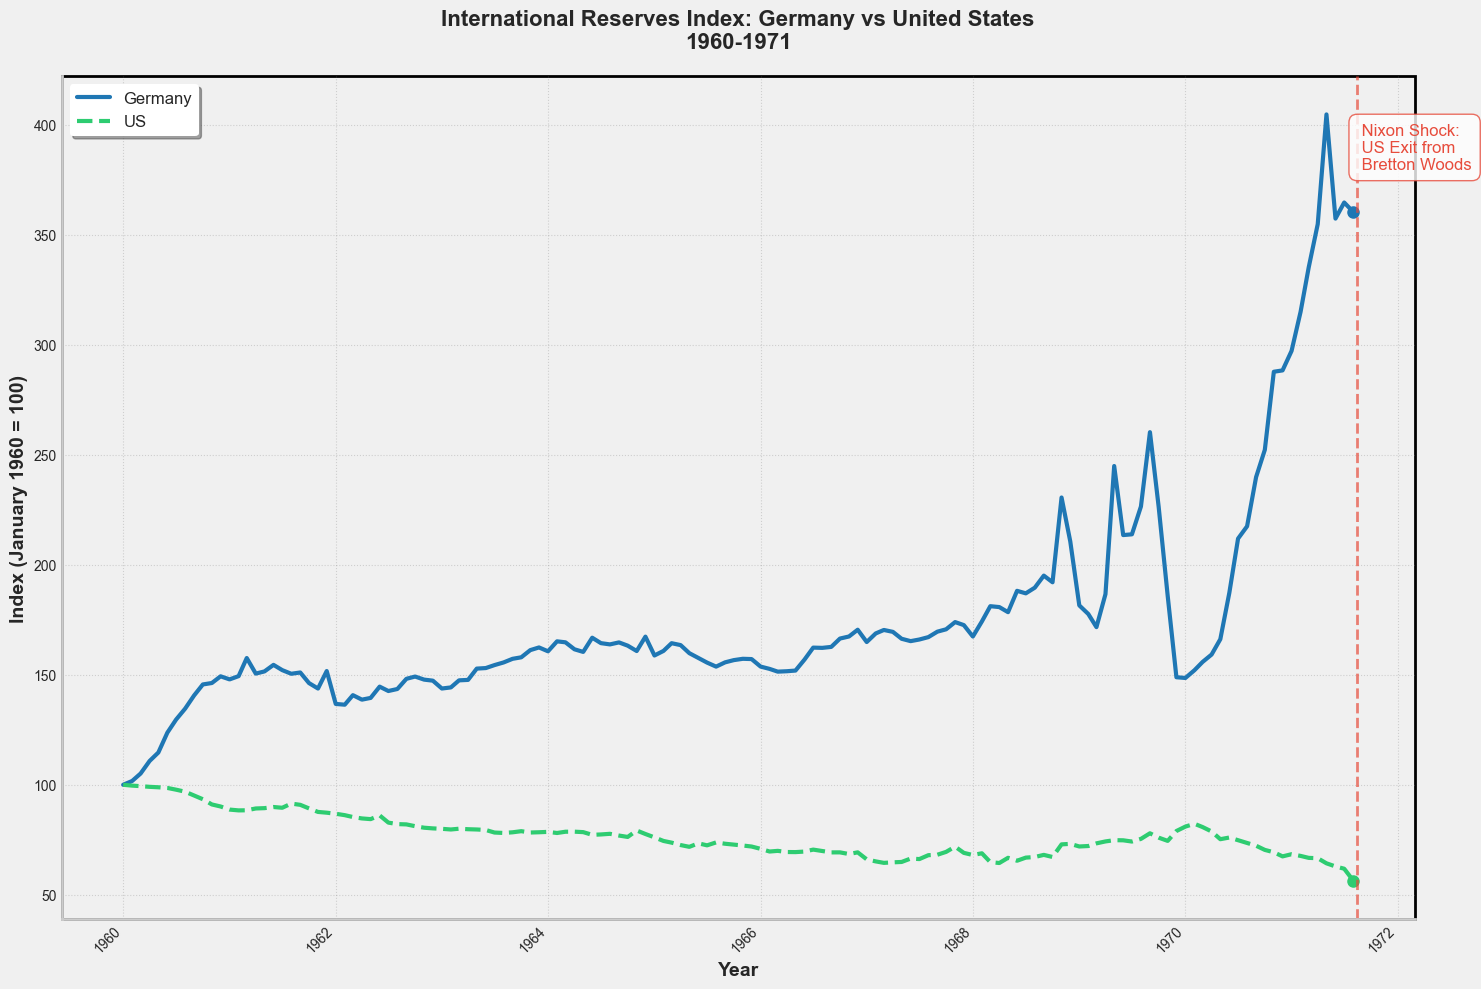

In [186]:
# Define the date range
start_date = pd.to_datetime('1960-01-01')
us_exit_date = pd.to_datetime('1971-08-15')  # Nixon Shock - US Exit from Bretton Woods

# Filter data for the specific time period and countries
mask = (merged_df['Date'] >= start_date) & (merged_df['Date'] <= us_exit_date)
plot_data = merged_df[mask].copy()

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure and axis with a specific background color
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Define better colors
colors = {'Germany': '#1f77b4', 'US': '#2ecc71'}
styles = {'Germany': '-', 'US': '--'}

# Plot data for both countries with enhanced styling
for country in ['Germany', 'US']:
    country_data = plot_data[plot_data['Country'] == country]
    line = ax.plot(country_data['Date'], 
                  country_data['International Reserves Index'],
                  label=country,
                  linewidth=3,
                  linestyle=styles[country],
                  color=colors[country])
    
    # Add end points markers
    ax.plot(country_data['Date'].iloc[-1], 
            country_data['International Reserves Index'].iloc[-1],
            marker='o',
            markersize=8,
            color=colors[country])

# Add vertical line for US exit with enhanced styling
ax.axvline(x=us_exit_date, color='#e74c3c', linestyle='--', alpha=0.7, linewidth=2)

# Add annotation with better formatting
ax.text(us_exit_date, ax.get_ylim()[1] * 0.95, 
        ' Nixon Shock:\n US Exit from\n Bretton Woods', 
        rotation=0,
        verticalalignment='top',
        horizontalalignment='left',
        color='#e74c3c',
        fontsize=12,
        bbox=dict(facecolor='white', 
                 edgecolor='#e74c3c',
                 boxstyle='round,pad=0.5',
                 alpha=0.8))

# Enhance grid
ax.grid(True, linestyle=':', alpha=0.3, color='gray')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Customize title and labels with better fonts
plt.title('International Reserves Index: Germany vs United States\n1960-1971', 
          fontsize=16, 
          pad=20, 
          fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Index (January 1960 = 100)', fontsize=14, fontweight='bold')

# Enhance legend
legend = plt.legend(fontsize=12, 
                   frameon=True,
                   facecolor='white',
                   edgecolor='none',
                   shadow=True,
                   loc='upper left')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add a subtle box around the plot
ax.set_frame_on(True)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth(2)

# Adjust layout
plt.tight_layout()


plt.show()

<font style='font-size:1.25em'>**5.2.2 Inflation and Industrial Production Graphs**</font>

- *Graph 1:* Monthly inflation for Germany 

- *Graph 2:* The difference between monthly inflation in Germany and the US (plotted as a single graph showing the difference).

- *Graph 3:* Monthly growth in industrial production for Germany (a line graph showing month-to-month changes).

- *Graph 4:* Growth in industrial production for Germany compared to 12 months ago (a line graph showing year-over-year comparisons for each month).

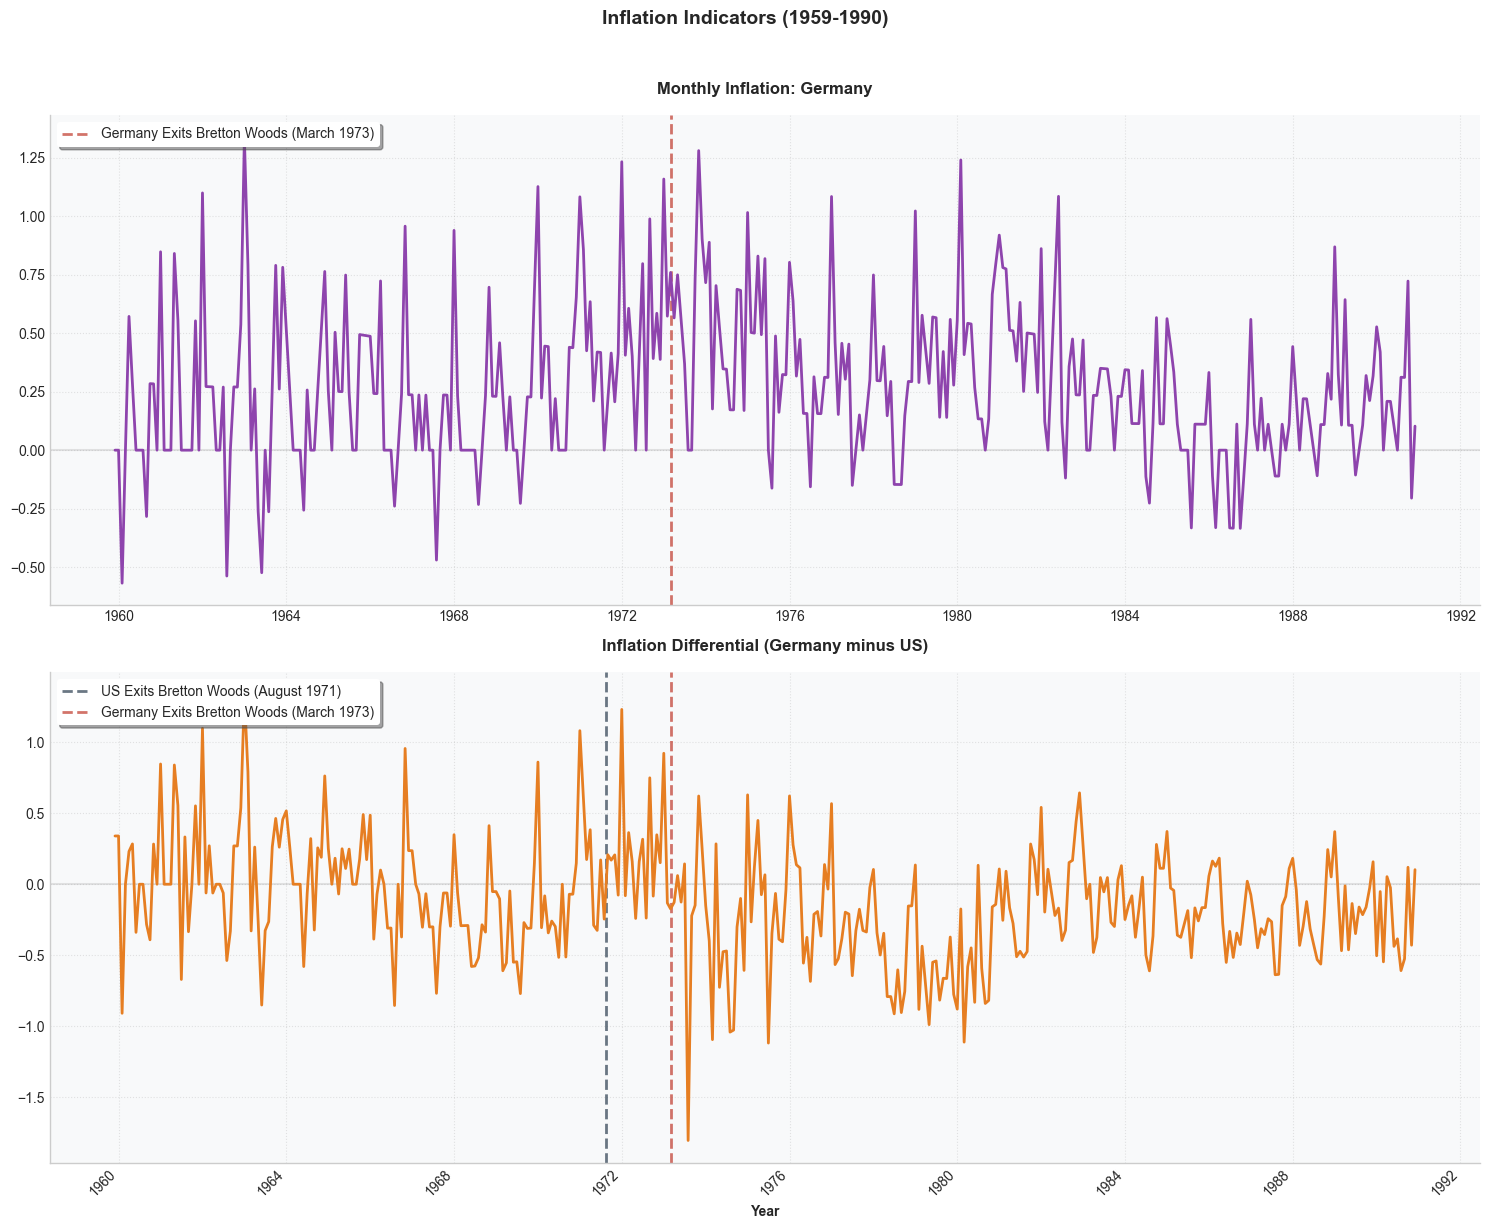

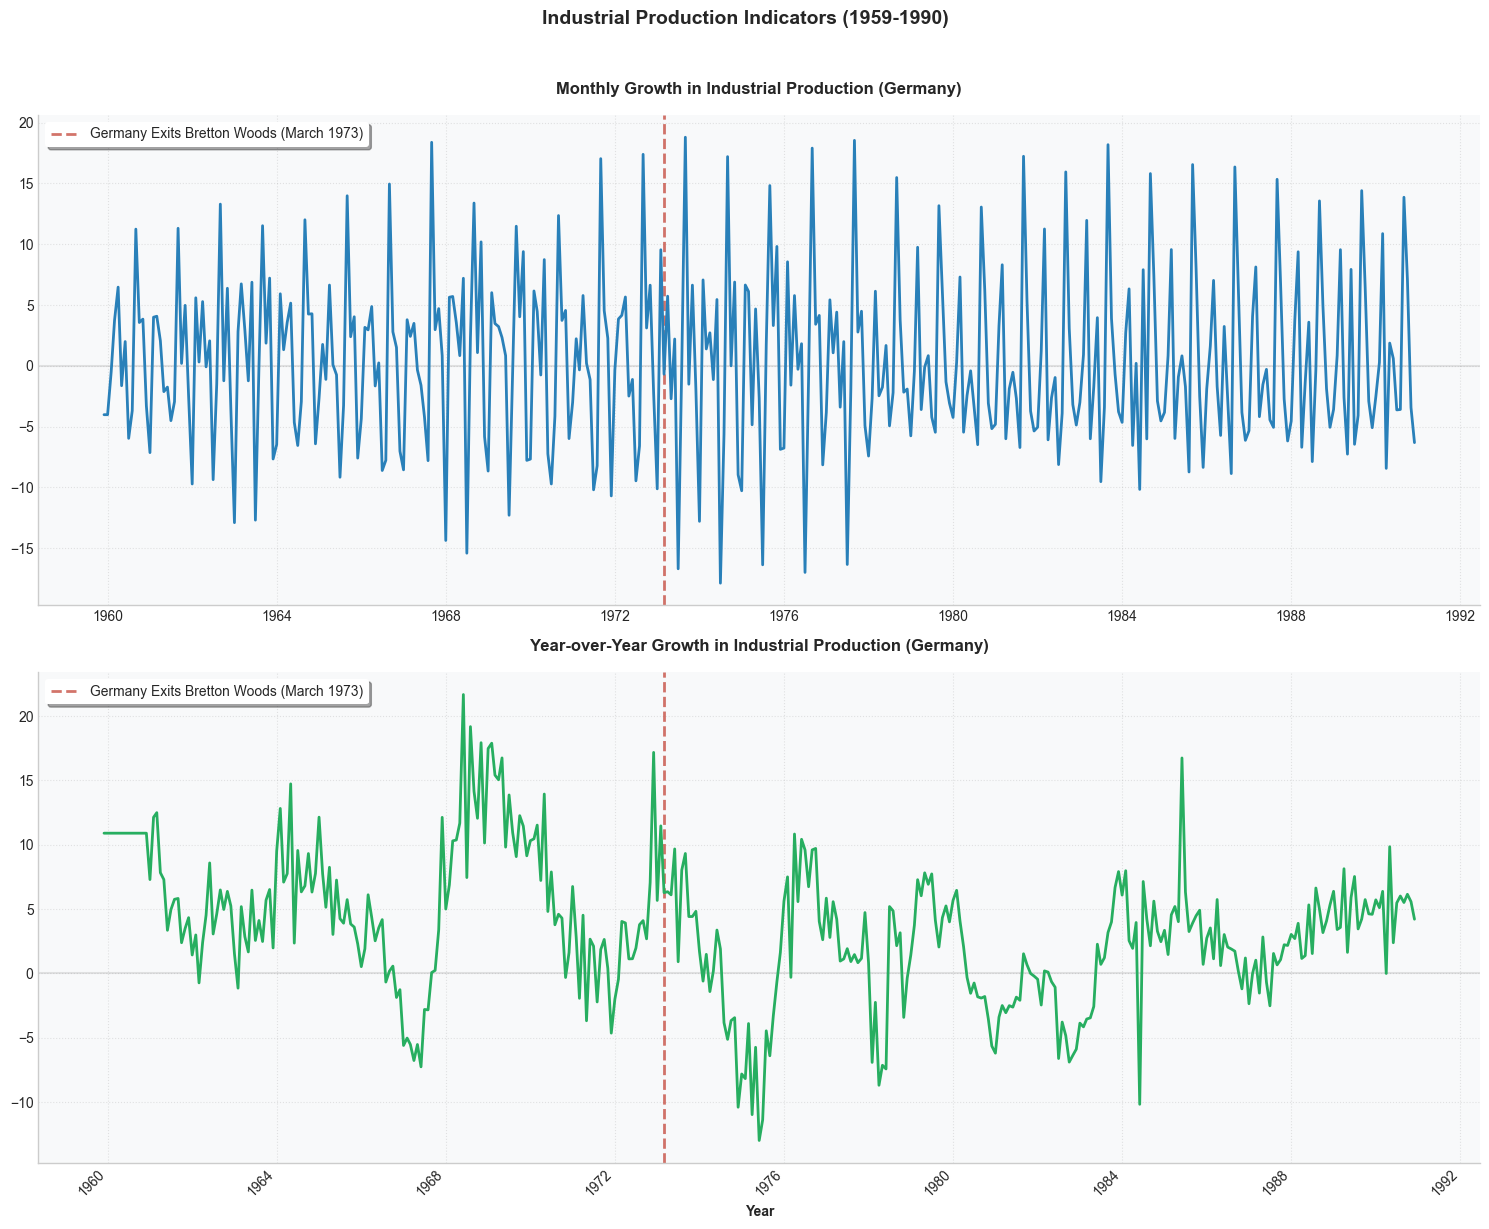

In [187]:
# Create two figures: one for inflation, one for production
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 12))

# Define Bretton Woods exit dates
germany_exit = pd.to_datetime('1973-03-01')
us_exit = pd.to_datetime('1971-08-15')  # Nixon Shock

# Define colors
colors = {
    'germany_line': '#8e44ad',    # Purple for Germany data
    'diff_line': '#e67e22',       # Orange for differential
    'monthly_prod': '#2980b9',    # Blue for monthly production
    'yearly_prod': '#27ae60',     # Green for yearly production
    'us_exit': '#2c3e50',         # Dark blue-gray for US exit
    'germany_exit': '#c0392b',    # Dark red for Germany exit
    'grid': '#ecf0f1'             # Light gray for grid
}

# Common formatting for all plots
for ax in [ax1, ax2, ax3, ax4]:
    # Add subtle grid
    ax.grid(True, linestyle=':', alpha=0.2, color='gray')
    ax.set_facecolor('#f8f9fa')  # Light background
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.2)
    ax.tick_params(axis='both', labelsize=10)
    
    if ax == ax2:  # For inflation differential plot only
        # Add both exit lines
        line_us = ax.axvline(x=us_exit, color=colors['us_exit'], linestyle='--', 
                           alpha=0.7, linewidth=2, label='US Exits Bretton Woods (August 1971)')
        line_germany = ax.axvline(x=germany_exit, color=colors['germany_exit'], linestyle='--', 
                                alpha=0.7, linewidth=2, label='Germany Exits Bretton Woods (March 1973)')
        # Add combined legend
        ax.legend(handles=[line_us, line_germany], 
                 fontsize=10, frameon=True, facecolor='white', 
                 edgecolor='none', shadow=True, loc='upper left')
    else:  # For other plots
        # Add only Germany's exit line
        line = ax.axvline(x=germany_exit, color=colors['germany_exit'], linestyle='--', 
                         alpha=0.7, linewidth=2, label='Germany Exits Bretton Woods (March 1973)')
        ax.legend(fontsize=10, frameon=True, facecolor='white', 
                 edgecolor='none', shadow=True, loc='upper left')

# Graph 1: Monthly Inflation (Germany only)
germany_data = merged_df[merged_df['Country'] == 'Germany']
ax1.plot(germany_data['Date'], 
         germany_data['Monthly Inflation Growth (%)'],
         color=colors['germany_line'],
         linewidth=2)

# Graph 2: Inflation Differential
germany_inf = merged_df[merged_df['Country'] == 'Germany']['Monthly Inflation Growth (%)']
us_inf = merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)']
inflation_diff = germany_inf.values - us_inf.values

ax2.plot(merged_df[merged_df['Country'] == 'Germany']['Date'], 
         inflation_diff,
         color=colors['diff_line'],
         linewidth=2)

# Graph 3: Monthly Industrial Production Growth
ax3.plot(germany_data['Date'], 
         germany_data['Monthly Industrial Production Growth (%)'],
         color=colors['monthly_prod'],
         linewidth=2)

# Graph 4: Year-over-Year Industrial Production Growth
ax4.plot(germany_data['Date'], 
         germany_data['Industrial Production YoY Growth (%)'],
         color=colors['yearly_prod'],
         linewidth=2)

# Set titles and labels with improved styling
for ax, title in zip([ax1, ax2, ax3, ax4], 
                    ['Monthly Inflation: Germany',
                     'Inflation Differential (Germany minus US)',
                     'Monthly Growth in Industrial Production (Germany)',
                     'Year-over-Year Growth in Industrial Production (Germany)']):
    ax.set_title(title, fontsize=12, pad=15, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, fontweight='bold')

# Add x-axis labels and rotate dates
for ax in [ax2, ax4]:
    ax.set_xlabel('Year', fontsize=10, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add main titles with improved styling
fig1.suptitle('Inflation Indicators (1959-1990)', 
              y=1.02, fontsize=14, fontweight='bold')
fig2.suptitle('Industrial Production Indicators (1959-1990)', 
              y=1.02, fontsize=14, fontweight='bold')

# Set figure background color
for fig in [fig1, fig2]:
    fig.patch.set_facecolor('white')
    fig.tight_layout()

plt.show()

ANALYSIS

<font style='font-size:1.25em'>**5.2.3 Comparison Statistics & Visualisation** </font>



Standard Deviations Before and After Bretton Woods:
                          Variable  Pre-BW  Post-BW  Ratio (Post/Pre)
      Nominal Exchange Rate Growth   0.864    2.840             3.286
         Real Exchange Rate Growth   0.931    2.862             3.074
                    Inflation Rate   0.341    0.307             0.898
            Inflation Differential   0.414    0.367             0.886
Industrial Production Growth (12m)   5.553    4.687             0.844


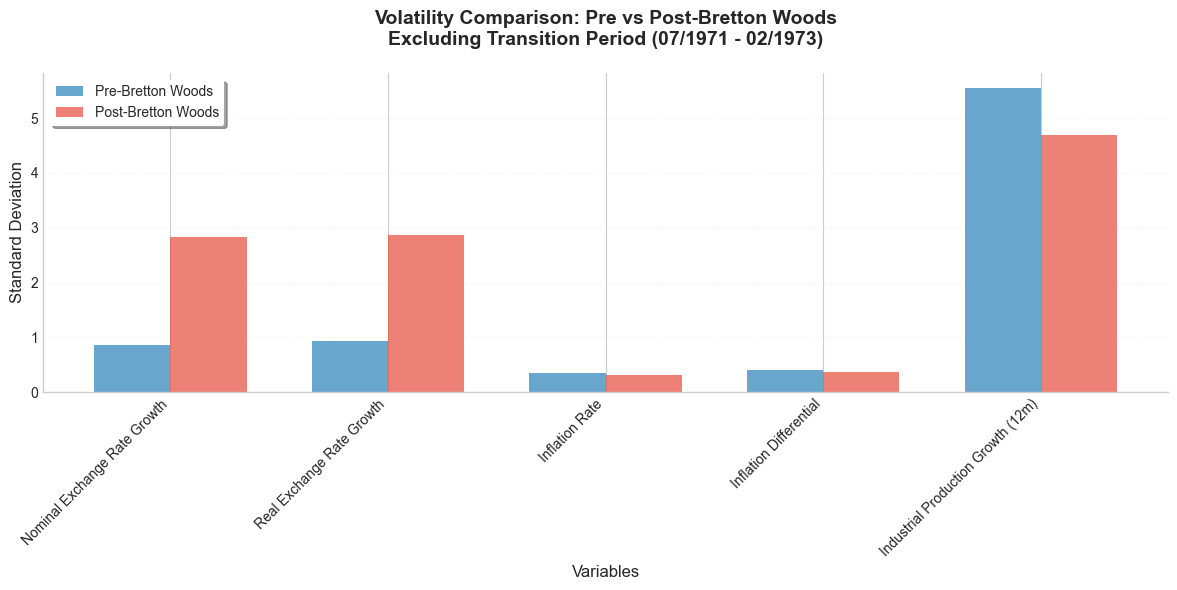

In [196]:
# Define periods
pre_bw = pd.to_datetime('1971-06-30')
post_bw = pd.to_datetime('1973-03-01')

# Filter for Germany and US separately
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
us_data = merged_df[merged_df['Country'] == 'US'].copy()

# Calculate inflation differential by aligning dates
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    us_data['Monthly Inflation Growth (%)'].values
)

# Variables to analyze
variables = {
    'Nominal Exchange Rate Growth (%)': 'Nominal Exchange Rate Growth',
    'Real Exchange Rate Growth (%)': 'Real Exchange Rate Growth',
    'Monthly Inflation Growth (%)': 'Inflation Rate',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': 'Industrial Production Growth (12m)'
}

# Calculate standard deviations
results = []
for var, name in variables.items():
    pre_std = germany_data[germany_data['Date'] <= pre_bw][var].std()
    post_std = germany_data[germany_data['Date'] >= post_bw][var].std()
    ratio = post_std / pre_std
    results.append({
        'Variable': name,
        'Pre-BW': pre_std,
        'Post-BW': post_std,
        'Ratio (Post/Pre)': ratio
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display formatted table
print("\nStandard Deviations Before and After Bretton Woods:")
print(results_df.round(3).to_string(index=False))

# Create bar chart
plt.figure(figsize=(12, 6))

# Plot bars
x = np.arange(len(variables))
width = 0.35

plt.bar(x - width/2, results_df['Pre-BW'], width, 
        label='Pre-Bretton Woods', color='#2980b9', alpha=0.7)
plt.bar(x + width/2, results_df['Post-BW'], width, 
        label='Post-Bretton Woods', color='#e74c3c', alpha=0.7)

# Customize chart
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.title('Volatility Comparison: Pre vs Post-Bretton Woods\nExcluding Transition Period (07/1971 - 02/1973)', 
          pad=20, fontsize=14, fontweight='bold')

# Rotate and align the tick labels so they look better
plt.xticks(x, [variables[key] for key in variables.keys()], 
           rotation=45, ha='right')

# Add legend
plt.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Add grid
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

**Why exclude data from 07/1971 - 02/1973?**

This transition period is excluded because:

1) It represents a time of unusual market uncertainty and volatility
2) The Bretton Woods system was effectively breaking down
3) Countries were adjusting their policies and markets were adapting


Including it would skew the comparison between stable pre- and post-Bretton Woods period, as the period represents neither a true fixed nor floating exchange rate regime

Below is a plot to show the yearly standard deviation for inflation, inflation difference, and industrial production growth from 1960 to 1990.

* The difference in the dates between Germany and US leaving the Bretton Woods system is denoted by the transition period

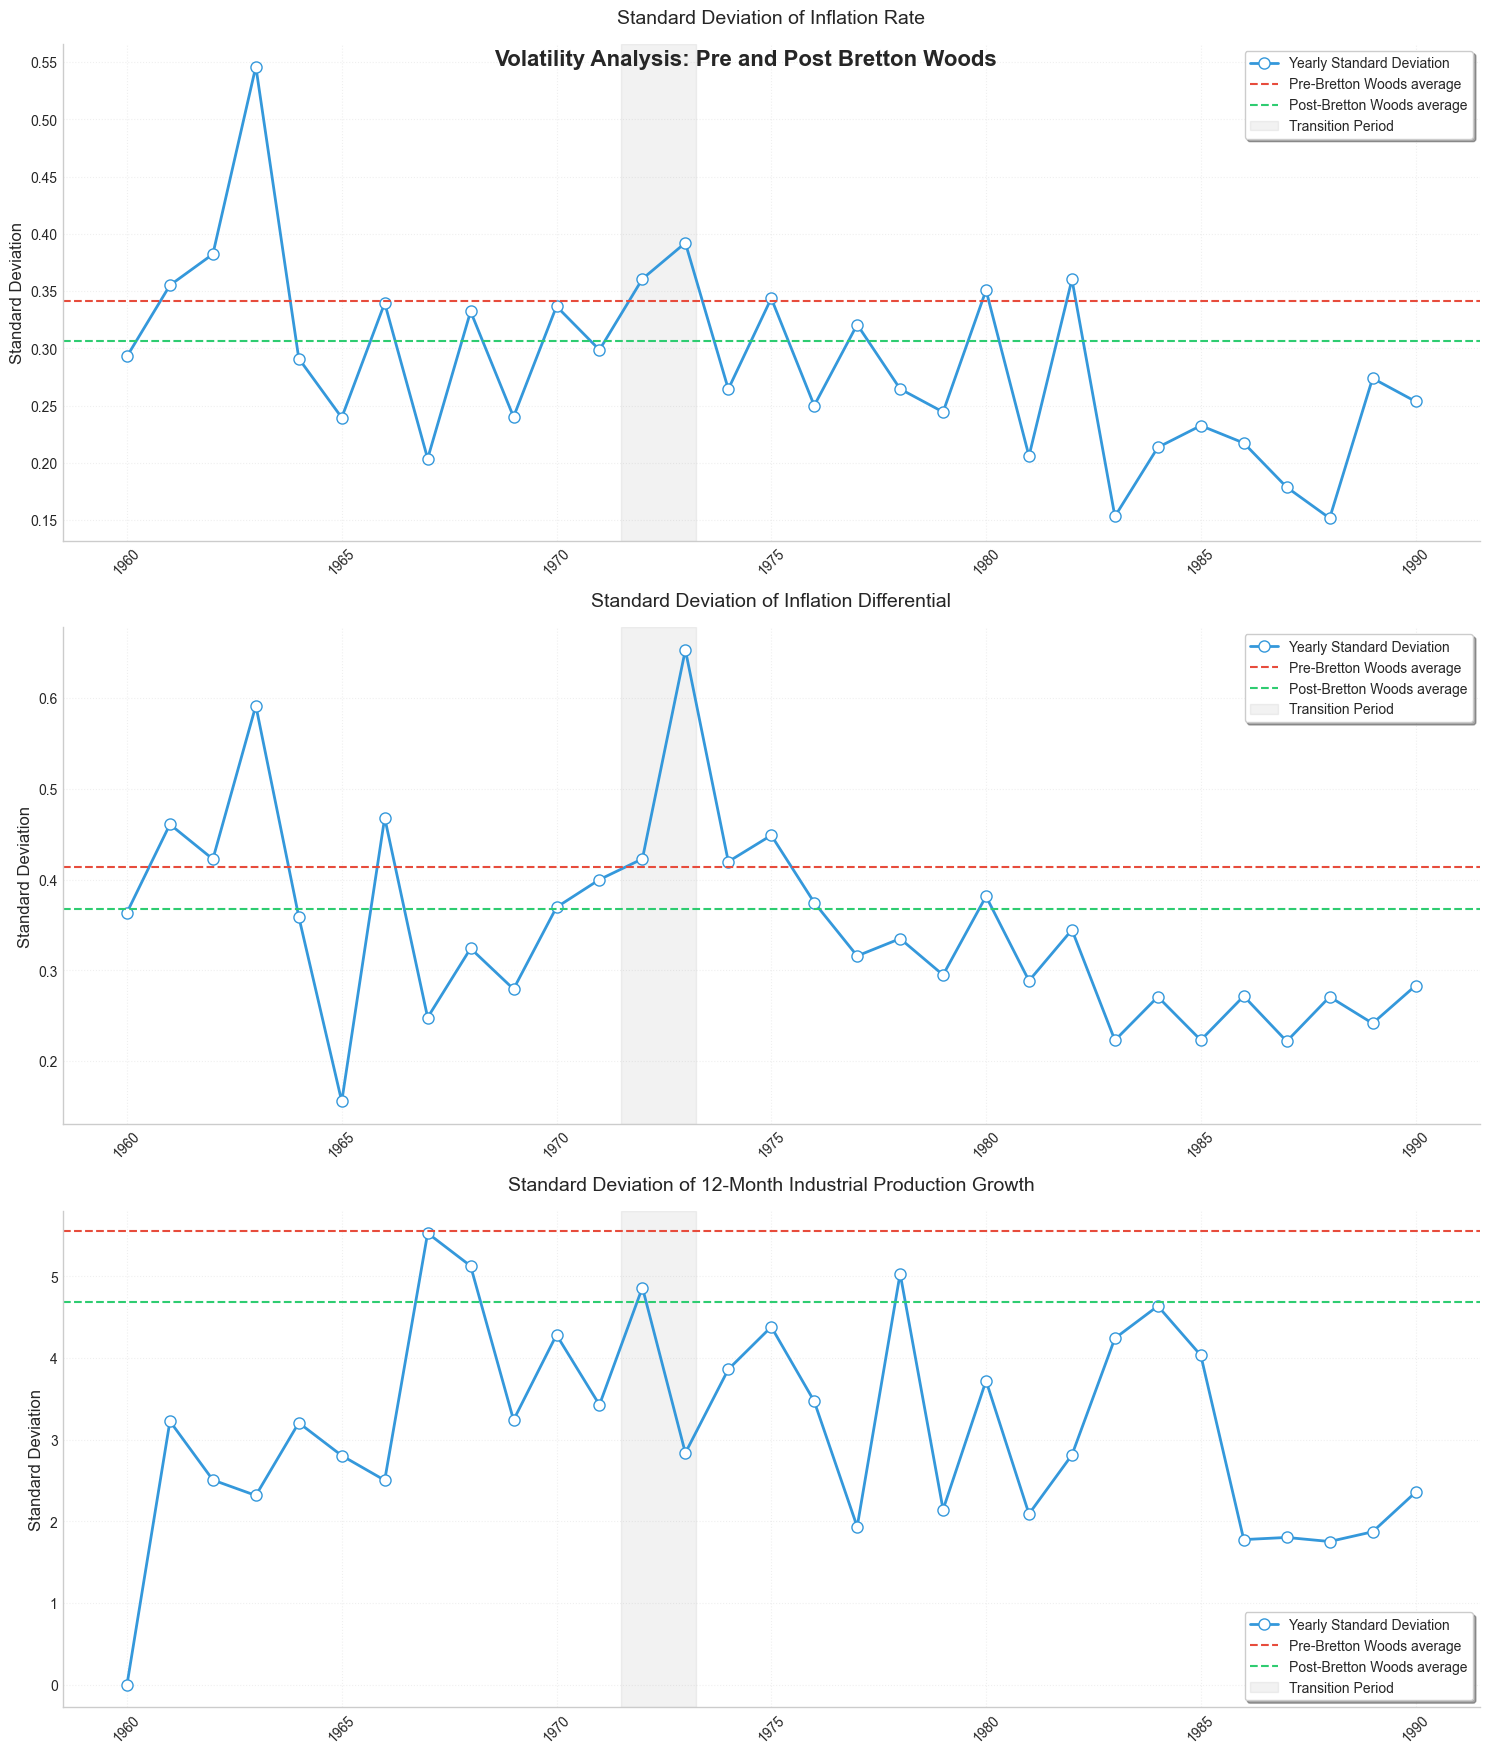

In [189]:
variables = {
    'Monthly Inflation Growth (%)': 'Inflation Rate',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': '12-Month Industrial Production Growth'
}

# Calculate inflation differential
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)'].values
)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Common formatting for all plots
for ax in axes:
    ax.grid(True, linestyle=':', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', rotation=45)

# Plot each variable
for idx, (var, title) in enumerate(variables.items()):
    # Calculate statistics
    yearly_std = germany_data.groupby(germany_data['Date'].dt.year)[var].std()
    pre_std = germany_data[germany_data['Date'] <= pre_bw][var].std()
    post_std = germany_data[germany_data['Date'] >= post_bw][var].std()
    
    # Create plot
    axes[idx].plot(yearly_std.index, yearly_std.values, 'o-', color='#3498db', 
                  linewidth=2, markersize=8, markerfacecolor='white', 
                  label='Yearly Standard Deviation')
    axes[idx].axhline(y=pre_std, color='#e74c3c', linestyle='--', 
                      label='Pre-Bretton Woods average')
    axes[idx].axhline(y=post_std, color='#2ecc71', linestyle='--', 
                      label='Post-Bretton Woods average')
    axes[idx].axvspan(1971.5, 1973.25, color='gray', alpha=0.1, 
                      label='Transition Period')
    
    # Add labels
    axes[idx].set_title(f'Standard Deviation of {title}', fontsize=14, pad=15)
    axes[idx].set_ylabel('Standard Deviation', fontsize=12)
    axes[idx].legend(frameon=True, facecolor='white', shadow=True)

# Final details
plt.suptitle('Volatility Analysis: Pre and Post Bretton Woods', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

<font style='font-size:1.25em'>**5.2.4 Regression Analysis** </font>

In [190]:
# Create 6-month period identifier
germany_data = merged_df[merged_df['Country'] == 'Germany'].copy()
germany_data['Period'] = germany_data['Date'].dt.year.astype(str) + '-' + \
                        ((germany_data['Date'].dt.month <= 6).map({True: 'H1', False: 'H2'}))

# Calculate inflation differential
germany_data['Inflation_Differential'] = (
    germany_data['Monthly Inflation Growth (%)'] - 
    merged_df[merged_df['Country'] == 'US']['Monthly Inflation Growth (%)'].values
)

# Variables to analyze
variables = {
    'Real Exchange Rate Growth (%)': 'Real Exchange Rate Growth',
    'Inflation_Differential': 'Inflation Differential',
    'Industrial Production YoY Growth (%)': '12-Month Industrial Production Growth'
}

# Calculate 6-month standard deviations
results = {}
for var in variables.keys():
    results[var] = germany_data.groupby('Period')[var].std()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.index.name = 'Period'

# Display first few periods
print("Standard Deviations by 6-month Period:")
print(results_df.head(10).round(3))


Standard Deviations by 6-month Period:
         Real Exchange Rate Growth (%)  Inflation_Differential  \
Period                                                           
1959-H2                            NaN                     NaN   
1960-H1                          0.484                   0.483   
1960-H2                          0.240                   0.240   
1961-H1                          1.802                   0.423   
1961-H2                          0.441                   0.442   
1962-H1                          0.449                   0.454   
1962-H2                          0.408                   0.408   
1963-H1                          0.799                   0.804   
1963-H2                          0.350                   0.351   
1964-H1                          0.364                   0.364   

         Industrial Production YoY Growth (%)  
Period                                         
1959-H2                                   NaN  
1960-H1                 

In [191]:
# Manual check for a specific period (e.g., 1970-H1)
print("\nManual Check for 1970-H1:")
check_period = '1970-H1'
for var, name in variables.items():
    # Get the data for the specific period
    period_data = germany_data[
        (germany_data['Date'].dt.year == 1970) & 
        (germany_data['Date'].dt.month <= 6)
    ][var]
    
    # Calculate standard deviation manually
    manual_std = period_data.std()
    
    # Get the value from our results
    calculated_std = results_df.loc[check_period, var]
    
    print(f"\n{name}:")
    print(f"Manual calculation: {manual_std:.3f}")
    print(f"Our results: {calculated_std:.3f}")
    print(f"Raw data points for verification:")
    print(period_data.round(3).values)


Manual Check for 1970-H1:

Real Exchange Rate Growth:
Manual calculation: 0.462
Our results: 0.462
Raw data points for verification:
[-0.851  0.306  0.082  0.341  0.26   0.297]

Inflation Differential:
Manual calculation: 0.466
Our results: 0.466
Raw data points for verification:
[ 0.861 -0.306 -0.082 -0.343 -0.26  -0.298]

12-Month Industrial Production Growth:
Manual calculation: 3.233
Our results: 3.233
Raw data points for verification:
[10.317 10.464 11.527  7.225 13.941  4.816]


In [192]:
import statsmodels.api as sm
import numpy as np

# Clean data
reg_data = results_df.copy()
reg_data = reg_data.replace([np.inf, -np.inf], np.nan).dropna()

# 1. Regression with Inflation Differential as dependent variable
X = sm.add_constant(reg_data['Real Exchange Rate Growth (%)'])
y1 = reg_data['Inflation_Differential']

model1 = sm.OLS(y1, X).fit()

# 2. Regression with Industrial Production Growth as dependent variable
y2 = reg_data['Industrial Production YoY Growth (%)']
model2 = sm.OLS(y2, X).fit()

# Print results
print("Regression 1: Inflation Differential Volatility")
print("=============================================")
print(model1.summary().tables[1])
print(f"R-squared: {model1.rsquared:.3f}")
print(f"Number of observations: {model1.nobs}")

print("\nRegression 2: Industrial Production Growth Volatility")
print("================================================")
print(model2.summary().tables[1])
print(f"R-squared: {model2.rsquared:.3f}")
print(f"Number of observations: {model2.nobs}")

Regression 1: Inflation Differential Volatility
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.3245      0.031     10.632      0.000       0.263       0.386
Real Exchange Rate Growth (%)     0.0085      0.014      0.617      0.540      -0.019       0.036
R-squared: 0.006
Number of observations: 62.0

Regression 2: Industrial Production Growth Volatility
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.6374      0.310      8.521      0.000       2.018       3.257
Real Exchange Rate Growth (%)    -0.0270      0.141     -0.192      0.848      -0.308       0.254
R-squared: 0.001
Number of observations: 62.0


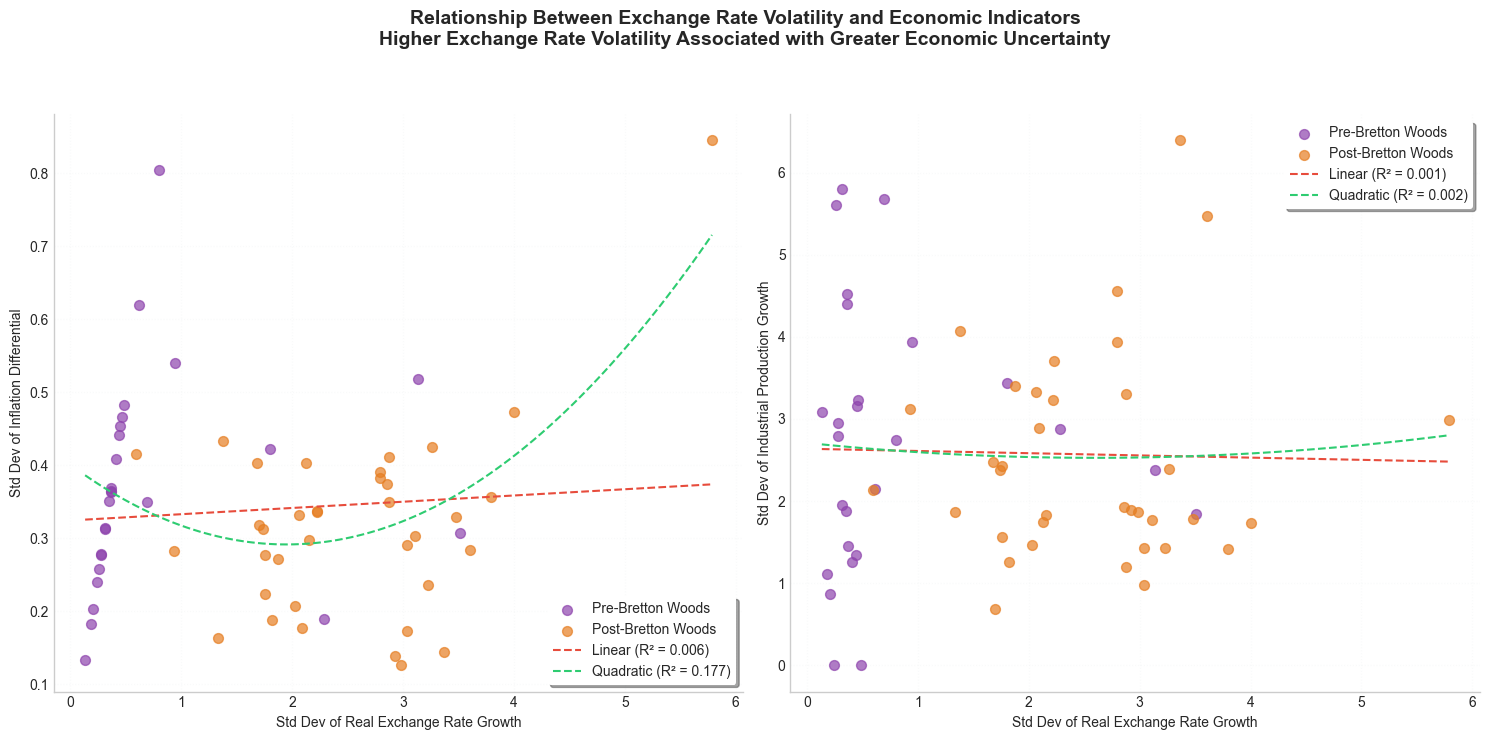

In [193]:
import statsmodels.api as sm
import numpy as np

# Define Bretton Woods exit date
bretton_woods_exit = pd.to_datetime('1973-03-01')

# Prepare Variables
X_linear = sm.add_constant(reg_data['Real Exchange Rate Growth (%)'])
X_quad = pd.DataFrame({
    'const': 1,
    'x': reg_data['Real Exchange Rate Growth (%)'],
    'x2': reg_data['Real Exchange Rate Growth (%)']**2
})

# Run regressions
models = {}
for dep_var in ['Inflation_Differential', 'Industrial Production YoY Growth (%)']:
    models[f'{dep_var}_linear'] = sm.OLS(reg_data[dep_var], X_linear).fit()
    models[f'{dep_var}_quad'] = sm.OLS(reg_data[dep_var], X_quad).fit()

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.patch.set_facecolor('white')

# Colors
colors = {
    'pre_bw': '#8e44ad',      # Purple for pre-Bretton Woods
    'post_bw': '#e67e22',     # Orange for post-Bretton Woods
    'linear': '#e74c3c',      # Red for linear fit
    'quad': '#2ecc71',        # Green for quadratic fit
    'grid': '#ecf0f1'         # Light gray for grid
}

# Plot settings for both graphs
for ax in [ax1, ax2]:
    ax.grid(True, linestyle=':', alpha=0.3, color=colors['grid'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# X values for smooth curves
X_smooth = np.linspace(reg_data['Real Exchange Rate Growth (%)'].min(),
                      reg_data['Real Exchange Rate Growth (%)'].max(), 100)

# Create period masks
pre_bw = reg_data.index <= '1973-03'
post_bw = reg_data.index > '1973-03'

# Plot 1: Inflation Differential
y1 = reg_data['Inflation_Differential']
# Plot pre and post Bretton Woods points separately
ax1.scatter(reg_data[pre_bw]['Real Exchange Rate Growth (%)'], y1[pre_bw], 
            alpha=0.7, color=colors['pre_bw'], label='Pre-Bretton Woods',
            s=50)
ax1.scatter(reg_data[post_bw]['Real Exchange Rate Growth (%)'], y1[post_bw], 
            alpha=0.7, color=colors['post_bw'], label='Post-Bretton Woods',
            s=50)

# Add fits
ax1.plot(X_smooth, 
         models['Inflation_Differential_linear'].params.iloc[0] + 
         models['Inflation_Differential_linear'].params.iloc[1] * X_smooth,
         color=colors['linear'], linestyle='--', 
         label=f'Linear (R² = {models["Inflation_Differential_linear"].rsquared:.3f})')

X_quad_smooth = pd.DataFrame({'const': 1, 'x': X_smooth, 'x2': X_smooth**2})
ax1.plot(X_smooth,
         models['Inflation_Differential_quad'].predict(X_quad_smooth),
         color=colors['quad'], linestyle='--',
         label=f'Quadratic (R² = {models["Inflation_Differential_quad"].rsquared:.3f})')

ax1.set_xlabel('Std Dev of Real Exchange Rate Growth')
ax1.set_ylabel('Std Dev of Inflation Differential')
ax1.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Plot 2: Industrial Production
y2 = reg_data['Industrial Production YoY Growth (%)']
# Plot pre and post Bretton Woods points separately
ax2.scatter(reg_data[pre_bw]['Real Exchange Rate Growth (%)'], y2[pre_bw], 
            alpha=0.7, color=colors['pre_bw'], label='Pre-Bretton Woods',
            s=50)
ax2.scatter(reg_data[post_bw]['Real Exchange Rate Growth (%)'], y2[post_bw], 
            alpha=0.7, color=colors['post_bw'], label='Post-Bretton Woods',
            s=50)

# Add fits
ax2.plot(X_smooth,
         models['Industrial Production YoY Growth (%)_linear'].params.iloc[0] + 
         models['Industrial Production YoY Growth (%)_linear'].params.iloc[1] * X_smooth,
         color=colors['linear'], linestyle='--',
         label=f'Linear (R² = {models["Industrial Production YoY Growth (%)_linear"].rsquared:.3f})')

ax2.plot(X_smooth,
         models['Industrial Production YoY Growth (%)_quad'].predict(X_quad_smooth),
         color=colors['quad'], linestyle='--',
         label=f'Quadratic (R² = {models["Industrial Production YoY Growth (%)_quad"].rsquared:.3f})')

ax2.set_xlabel('Std Dev of Real Exchange Rate Growth')
ax2.set_ylabel('Std Dev of Industrial Production Growth')
ax2.legend(frameon=True, facecolor='white', 
          edgecolor='none', shadow=True)

# Main title
plt.suptitle('Relationship Between Exchange Rate Volatility and Economic Indicators\n' +
             'Higher Exchange Rate Volatility Associated with Greater Economic Uncertainty',
             fontsize=14, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()

plt.show()